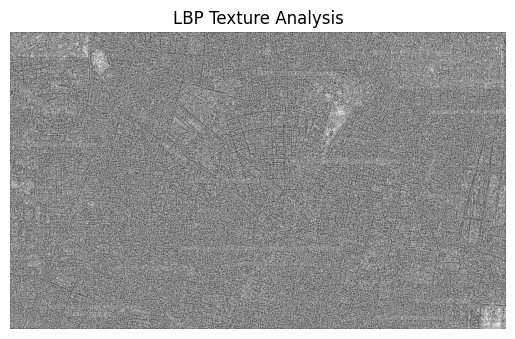

True

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define paths
location_name = "Milk_Colony"
input_image_path = f"./Locations/{location_name}.jpg"
output_dir = f"./output/{location_name}"
os.makedirs(output_dir, exist_ok=True)

# Load image
image = cv2.imread(input_image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {input_image_path}")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply LBP
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(gray, n_points, radius, method="uniform")

# Normalize LBP
lbp_normalized = (lbp - lbp.min()) / (lbp.max() - lbp.min())

# Save LBP Image
lbp_output = os.path.join(output_dir, "LBP_Texture.png")
cv2.imwrite(lbp_output, (lbp_normalized * 255).astype(np.uint8))

# Display LBP
plt.imshow(lbp_normalized, cmap="gray")
plt.title("LBP Texture Analysis")
plt.axis("off")
plt.savefig(os.path.join(output_dir, "LBP_Texture_Analysis.png"))
plt.show()

# Generate segmentation mask (dummy mask, replace with actual labels)
mask = np.zeros_like(gray)
mask[gray > np.percentile(gray, 70)] = 1  # Example thresholding for water areas
mask[gray < np.percentile(gray, 30)] = 2  # Soil region

# Save segmentation mask
mask_output = os.path.join(output_dir, "Segmentation_Mask.png")
cv2.imwrite(mask_output, (mask * 127).astype(np.uint8))


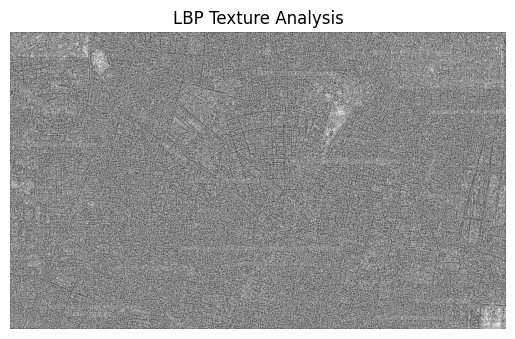

True

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define paths
location_name = "Milk_Colony"
input_image_path = f"./Locations/{location_name}.jpg"
output_dir = f"./output/{location_name}"
os.makedirs(output_dir, exist_ok=True)

# Load image
image = cv2.imread(input_image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {input_image_path}")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply LBP
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(gray, n_points, radius, method="uniform")

# Normalize LBP
lbp_normalized = (lbp - lbp.min()) / (lbp.max() - lbp.min())

# Save LBP Image
lbp_output = os.path.join(output_dir, "LBP_Texture.png")
cv2.imwrite(lbp_output, (lbp_normalized * 255).astype(np.uint8))

# Display LBP
plt.imshow(lbp_normalized, cmap="gray")
plt.title("LBP Texture Analysis")
plt.axis("off")
plt.savefig(os.path.join(output_dir, "LBP_Texture_Analysis.png"))
plt.show()

# Generate segmentation mask (dummy mask, replace with actual labels)
mask = np.zeros_like(gray)
mask[gray > np.percentile(gray, 70)] = 1  # Example thresholding for water areas
mask[gray < np.percentile(gray, 30)] = 2  # Soil region

# Save segmentation mask
mask_output = os.path.join(output_dir, "Segmentation_Mask.png")
cv2.imwrite(mask_output, (mask * 127).astype(np.uint8))


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define U-Net Model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(512, 3, activation="relu", padding="same")(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation="relu", padding="same")(merge5)
    conv5 = Conv2D(256, 3, activation="relu", padding="same")(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation="relu", padding="same")(merge6)
    conv6 = Conv2D(128, 3, activation="relu", padding="same")(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation="relu", padding="same")(merge7)
    conv7 = Conv2D(64, 3, activation="relu", padding="same")(conv7)

    # Output layer
    output = Conv2D(3, 1, activation="softmax", padding="same")(conv7)  # 3 classes: Water, Soil, Vegetation

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

# Load Data
X_train, X_val, y_train, y_val = train_test_split(
    np.expand_dims(gray, axis=-1), to_categorical(mask), test_size=0.2, random_state=42
)

X_train = np.expand_dims(X_train, axis=0)
y_train = np.expand_dims(y_train, axis=0)
X_val = np.expand_dims(X_val, axis=0)
y_val = np.expand_dims(y_val, axis=0)

# Initialize and Train Model
model = unet_model()
model.fit(X_train, y_train, batch_size=1, epochs=50, validation_data=(X_val, y_val))

# Save Model
model.save(os.path.join(output_dir, "unet_recharge_zone_model.h5"))


Epoch 1/50


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 256, 256, 1), found shape=(1, 732, 1529)

In [6]:
# Load Trained Model
model = tf.keras.models.load_model(os.path.join(output_dir, "unet_recharge_zone_model.h5"))

# Predict on New Image
image_resized = cv2.resize(gray, (256, 256))
input_image = np.expand_dims(image_resized, axis=(0, -1))

prediction = model.predict(input_image)
predicted_mask = np.argmax(prediction, axis=-1)[0]

# Visualize Prediction
plt.imshow(predicted_mask, cmap="jet")
plt.title("Predicted Recharge Zones")
plt.axis("off")
plt.savefig(os.path.join(output_dir, "Predicted_Recharge_Zones.png"))
plt.show()

# Save Prediction
cv2.imwrite(os.path.join(output_dir, "Predicted_Recharge_Zones.png"), (predicted_mask * 127).astype(np.uint8))


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './output/Milk_Colony\unet_recharge_zone_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)